# Dataset Generation

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Templates
we have 39 kinds of templates for 4 languages, but we only use 'de' and 'en' here for testing.

In [2]:
# templates
templates = pd.read_json("data/templates.json")
init_uttr_updated = pd.read_csv("data/InitUtterance_list_updated.csv")
templates_updated = templates.merge(init_uttr_updated, on='id')
templates_updated = templates_updated[['id', 'de', 'en']] #'fr', 'it',
templates_updated.head()

,id,de,en
0,MyCloud.OpenArea.Init.Utterance,{'texts': [{'ttsText': '{MyCloudArea} auf #myC...,{'texts': [{'ttsText': 'show {MyCloudArea} on ...
1,Router.SwitchOnWiFi.Init.Utterance,"{'texts': [{'ttsText': 'aktiviere das Wlan'}, ...","{'texts': [{'ttsText': 'activate the Wi-Fi'}, ..."
2,Tv.GenericExitToTv.Init.Utterance,{'texts': [{'ttsText': 'gehe zurück zum Fernse...,"{'texts': [{'ttsText': 'back to TV'}, {'ttsTex..."
3,Router.SwitchOffWiFi.Init.Utterance,{'texts': [{'ttsText': 'deaktiviere das Wlan'}...,{'texts': [{'ttsText': 'can you please switch ...
4,Tv.RadioChannelChange.Init.Utterance,{'texts': [{'ttsText': 'auf Radio {RadioChanne...,{'texts': [{'ttsText': 'can you turn on radio ...


In [3]:
templates_updated.describe()

,id,de,en
count,39,39,39
unique,39,39,39
top,Tv.VolumeUnmute.Init.Utterance,{'texts': [{'ttsText': '{SmartHomeSceneName} S...,{'texts': [{'ttsText': 'activate {SmartHomeSce...
freq,1,1,1


## Entities
65K entities of 33 different types are included.
1/3 of them are from German environment.

In [3]:
# entities
entities = pd.read_json("data/entities.json")
entities = entities[['value', 'type', 'language', 'normalizedValue', 'aliases']]
entities.head()

,value,type,language,normalizedValue,aliases
0,Widnau,LocalsearchLocation,de,widnau,[]
1,Zurigo,LocalsearchLocation,it,zurigo,[]
2,Solothurn,LocalsearchLocation,de,solothurn,[]
3,Muttenz,LocalsearchLocation,de,muttenz,[]
4,Lyss,LocalsearchLocation,de,lyss,[]


In [5]:
entities.describe()


,value,type,language,normalizedValue,aliases
count,65471,65471,65471,65471,65471
unique,51272,33,4,52082,3793
top,Golf,SeriesName,de,golf,[]
freq,20,17913,22746,20,59649


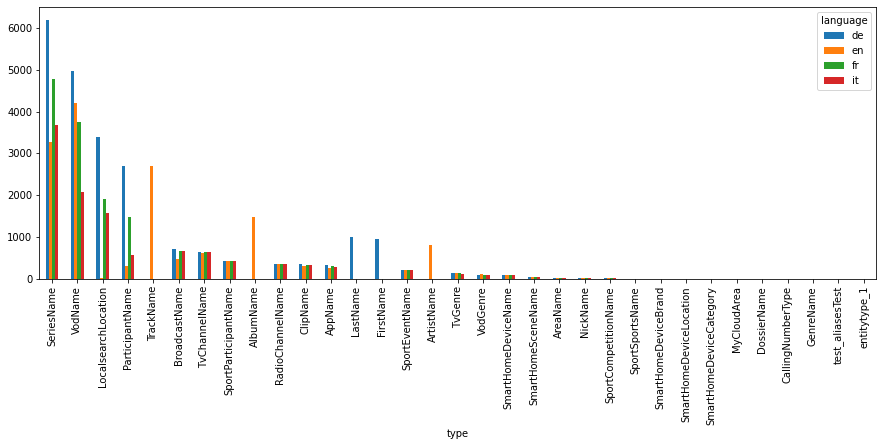

In [4]:
df = entities[['type', 'language']]
df = df.groupby(['type','language']).size().reset_index(name='count')
df2 = df.pivot(index='type', columns='language', values='count')
df2['sum'] = 0
df2 = df2.fillna(0)
for lang in ['de', 'en', 'fr', 'it',]:
    df2['sum'] += df2[lang]
# df.sort_values('count', ascending=False)
p = df2.sort_values('sum', ascending=False)[['de', 'en', 'fr', 'it']].plot(kind='bar', figsize=(15, 5))

### Find the representative
One entity usually has various name, thus, to improve speed, we need to find the representative ones that could retrieve all.
Considering the speaking speed and noise of ASR, we decide to:
1. Combine abbreviation as a upper case word (s r f, S R F -> SRF)
2. Keep the uppercase one if two words spell same (Schweiz, schweiz -> Schweiz)

In [5]:
# TODO: deal with case "a"
from generator.tools import filter_aliases
sample_aliases1 = [
    "TF 3",         # value
    "TF three",     # normalized
    "T F 3",        # alias
    "t f three",    # alias
    "t f 3"         # alias
    ]
filter_aliases(sample_aliases1,'en')

['TF 3']

In [6]:
sample_aliases2 = [
    "S R F",
    "s r f",
    "SRF",

    "SRF 1",
    "S R F 1",
    "s r f eins",
    "SRF eins",
    "SRF einz",
    "S R F einz",
    "S R F eis",
    "s r f eis",
    "s r f einz",
    "SRF eis",

    "D R S",
    "D R S 1",
    "DRS",
    "d r s",
    "DRS 1",
    "d r s eins",
    "DRS eins",

    "schweizer",
    "Schweizer",
    "Schweiz 1",
    "schweiz eins"
	]
filter_aliases(sample_aliases2, 'de')

['Schweizer',
 'SRF',
 'SRF eis',
 'SRF einz',
 'DRS',
 'Schweiz 1',
 'SRF 1',
 'DRS 1',
 'SR']

## Read custom entities
Since not all entity types in template are included in entity table, such as channel num/ date/ time,
we need to create them according to language specific rules.

In [7]:
# entities_custom
entities_custom = pd.read_json("data/entities_custom.json")
entities_updated = pd.concat([entities, entities_custom]).reset_index()

## Read custom template
For time related templates:
* Localsearch.TemperatureInfo.Init.Utterance
* Localsearch.RainInfo.Init.Utterance
* Localsearch.WeatherInfo.Init.Utterance

exist problem that they use "TimeStamp" to represent both clock time (3 o'clock) and day time ("tomorrow", "Monday", etc.)
But their use cases are different. So we updated general "TimeStamp" -> "TimeStampDay" and "TimeStampTime" for DE and EN

In [ ]:
# update template
df = pd.read_json("data/timestamp_de_noted.json")
templates_updated.update(df)

df = pd.read_json("data/timestamp_en_noted.json")
templates_updated.update(df)

## Generation

In [17]:
from generator.module import Generator
gen = Generator(templates=templates_updated, entities=entities_updated, method='one')

t = gen.get_command(target_id='SmartHome.SwitchOnDevice.Init.Utterance',
                target_lang='en',
                 verbose=True)

Choose template: 
	['can you please switch on device {SmartHomeDeviceName}']
After tag removal: 
	[('can you please switch on device hue white lamp 3', '{Template} {Template} {Template} {Template} {Template} {Template} {SmartHomeDeviceName} {SmartHomeDeviceName} {SmartHomeDeviceName} {SmartHomeDeviceName}')]


In [24]:
command_pool = []
sample_df = pd.DataFrame(columns=['de','de_label', 'en', 'en_label'], index=templates_updated.id)
for temp in templates_updated.id:
    for lang in ['en', 'de']:
        sample_df.loc[temp, lang], sample_df.loc[temp, lang + '_label'] = gen.get_command(target_id=temp,
                                                                                            target_lang=lang,
                                                                                             verbose=False)[0]
sample_df

,de,de_label,en,en_label
id,,,,
MyCloud.OpenArea.Init.Utterance,würdest du bitte auf myCloud zu Bilder Sammlun...,{Template} {Template} {Template} {Template} {T...,I want to see foto stream on myCloud,{Template} {Template} {Template} {Template} {M...
Router.SwitchOnWiFi.Init.Utterance,drahtlose Verbindung herstellen,{Template} {Template} {Template},connect to theWi-Fi,{Template} {Template} {Template}-{Template}
Tv.GenericExitToTv.Init.Utterance,zum Fernsehen,{Template} {Template},live TV,{Template} {Template}
Router.SwitchOffWiFi.Init.Utterance,mach bitte das Wlan aus,{Template} {Template} {Template} {Template} {T...,internet off please,{Template} {Template} {Template}
Tv.RadioChannelChange.Init.Utterance,das Radioprogramm ändern,{Template} {Template} {Template},I want to change the radio station,{Template} {Template} {Template} {Template} {T...
Router.ShowGuestWiFiPassword.Init.Utterance,kannst du mir das Gäste Wlan Passwort zeigen,{Template} {Template} {Template} {Template} {T...,can you show me the guest Wi-Fi password,{Template} {Template} {Template} {Template} {T...
Tv.InitiateService.Init.Utterance,TV anmachen,{Template} {Template},please turn my TV box on,{Template} {Template} {Template} {Template} {T...
Tv.OpenApplication.Init.Utterance,starte die App,{Template} {Template} {Template},got to France 24,{Template} {Template} {AppName} {AppName}
SmartHome.SwitchOnDevice.Init.Utterance,kannst du bitte das Gerät WC anmachen,{Template} {Template} {Template} {Template} {T...,start device Plant light in the dining room,{Template} {Template} {SmartHomeDeviceName} {S...


In [25]:
# check a value
sample_df.loc['Localsearch.RainInfo.Init.Utterance', 'en']

'is it raining 10.17'

In [26]:
sample_df.loc['Localsearch.RainInfo.Init.Utterance', 'en_label']

'{Template} {Template} {Template} {LocalsearchTimeStampStartDay}'

## Test tools

In [20]:
miss_id = ['Localsearch.TemperatureInfo.Init.Utterance' ,
            'Localsearch.RainInfo.Init.Utterance',
            'Localsearch.WeatherInfo.Init.Utterance' ]

k  = templates_updated[[t in miss_id for t in templates_updated.id]]
k[['id', 'de']].to_json("data/timestamp_de.json")
k[['id', 'en']].to_json("data/timestamp_en.json")


In [23]:
from generator.normalizer import Normalizer
Normalizer().normalize_text("ProCreate", 'en')



'procreate'